In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [247]:
def getSetRatings(setFName):
    uSetRatings = {}
    nSets = 0
    with open(setFName, 'r') as f:
        for line in f:
            cols   = line.strip().split(',')
            user   = int(cols[0])
            uItems = map(int, cols[1].split('-'))
            rating = float(cols[2])
            if user not in uSetRatings:
                uSetRatings[user] = []
            uSetRatings[user].append((uItems, rating))
            nSets+= 1
    print 'No. of sets: ', nSets
    return uSetRatings

def getUIRatings(ratFName):
    uiRatings = {}
    uinnz = 0
    with open(ratFName, 'r') as f:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            item = int(cols[1])
            rating = float(cols[2])
            if user not in uiRatings:
                uiRatings[user] = {}
            uiRatings[user][item] = rating
            uinnz += 1
    print 'No. of u-i ratings: ', uinnz
    return uiRatings

import datetime
def getUITstamp(ratFName):
    uiTstamp = {}
    with open(ratFName, 'r') as f:
        for line in f:
            cols = line.strip().split(',')
            user = int(cols[0])
            item = int(cols[1])
            rating = float(cols[2])
            tstampStr = cols[3]
            tstamp = datetime.datetime.strptime(tstampStr, "%Y-%m-%d %H:%M:%S")
            if user not in uiTstamp:
                uiTstamp[user] = {}
            uiTstamp[user][item] = tstamp
    return uiTstamp


In [248]:
uSetRatings = getSetRatings('db_filt_set_ratings.csv')
uiRatings = getUIRatings('db_ui_ratings.csv')
uiTstamp = getUITstamp('db_ui_ratings.csv')

No. of sets:  29516
No. of u-i ratings:  510032


In [143]:
def avgSetRat(user, items):
    rat = 0.0
    for item in items:
        rat += uiRatings[user][item]
    rat = rat/len(items)
    return rat

UNDER_RATED_SET   = 1
OVER_RATED_SET    = 2
NEITHER_RATED_SET = 0
def isSetUnderOverRat(user, items, rating):
    avgRat = avgSetRat(user, items)
    if avgRat >= rating + 0.5:
        #under rat
        return UNDER_RATED_SET
    elif avgRat <= rating - 0.5:
        #over rat
        return OVER_RATED_SET
    else:
        return NEITHER_RATED_SET
    
def hexbin(x, y, xlabel, ylabel, label='count'):
    plt.hexbin(x, y, gridsize=10, cmap=plt.cm.YlOrRd_r, bins=None)
    plt.axis([0.5, 5, 0.5, 5])
    cb = plt.colorbar()
    cb.set_label(label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

def rmse(l1, l2):
    a1 = np.asarray(l1)
    a2 = np.asarray(l2)
    n = len(l1)
    return np.sqrt(np.sum(np.square(a1 - a2))/n)

def getUserSetsAvgRatings():
    origSetRatings = []
    origAvgSetRatings = []
    underRatedCount = 0
    overRatedCount = 0

    nUnderRatedSets = 0
    seUnderRatedSets = 0

    nOverRatedSets = 0
    seOverRatedSets = 0

    nNeitherSets = 0
    seNeitherSets = 0
    
    for user, itemsSetsNRat in uSetRatings.iteritems():
        if user not in uiRatings:
            print 'no ratings for ', user
            continue
        userUnderRatedCount[user]  = 0
        userOverRatedCount[user] = 0
        for itemSetNRat in itemsSetsNRat:
            
            items  = itemSetNRat[0]
            setRat = itemSetNRat[1]
            avgRat = avgSetRat(user, items)
            
            for item in items:
                if item not in itemUnderRatedCount:
                    itemUnderRatedCount[item] = 0
                if item not in itemOverRatedCount:
                    itemOverRatedCount[item] = 0
                if item not in itemSetCount:
                    itemSetCount[item] = 0
                if item not in uiRatings[user]:
                    print 'Item: ', item, ' not found for user: ', user
                itemSetCount[item] += 1
            
            setRatingType = isSetUnderOverRat(user, items, setRat)
            
            if setRatingType == UNDER_RATED_SET:
                nUnderRatedSets += 1
                seUnderRatedSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uUnderRatedSetRatings:
                    uUnderRatedSetRatings[user] = []
                uUnderRatedSetRatings[user].append(itemSetNRat)
                underRatedCount += 1
                userUnderRatedCount[user] += 1
                for item in items:
                    itemUnderRatedCount[item] += 1
            elif setRatingType == OVER_RATED_SET:
                nOverRatedSets += 1
                seOverRatedSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uOverRatedSetRatings:
                    uOverRatedSetRatings[user] = []
                uOverRatedSetRatings[user].append(itemSetNRat)
                overRatedCount += 1
                userOverRatedCount[user] += 1
                for item in items:
                    itemOverRatedCount[item] += 1
            else:
                nNeitherSets += 1
                seNeitherSets += (avgRat - setRat)*(avgRat - setRat)
                if user not in uNeitherRatedSetRatings:
                    uNeitherRatedSetRatings[user] = []
                uNeitherRatedSetRatings[user].append(itemSetNRat)
                
            origSetRatings.append(setRat)
            origAvgSetRatings.append(avgRat)
    hexbin(origSetRatings, origAvgSetRatings, 'set ratings', 'average ratings')
    print 'rmse: ', rmse(origSetRatings, origAvgSetRatings)
    
    print 'nUnderRatedSets: ', nUnderRatedSets, ' underRatedRMSE: ', np.sqrt(seUnderRatedSets/nUnderRatedSets)
    print 'nOverRatedSets: ', nOverRatedSets, ' overRatedRMSE: ', np.sqrt(seOverRatedSets/nOverRatedSets)
    print 'nNeitherSets: ', nNeitherSets, ' neitherSetsRMSE: ', np.sqrt(seNeitherSets/nNeitherSets)
    
    print 'underRatedCount: ', underRatedCount, len(uUnderRatedSetRatings)
    print 'overRatedCount: ', overRatedCount, len(uOverRatedSetRatings)
    return (origSetRatings, origAvgSetRatings)

rmse:  0.597961482605
nUnderRatedSets:  6571  underRatedRMSE:  0.962637906724
nOverRatedSets:  5220  overRatedRMSE:  0.810604996142
nNeitherSets:  17725  neitherSetsRMSE:  0.241593207388
underRatedCount:  6571 731
overRatedCount:  5220 706


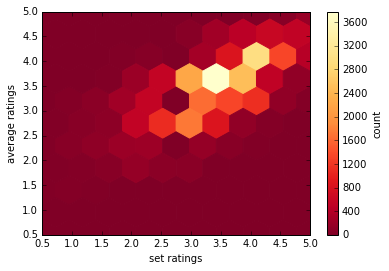

In [144]:
userUnderRatedCount = {}
userOverRatedCount  = {}
itemUnderRatedCount = {}
itemOverRatedCount  = {}
itemSetCount        = {}

uUnderRatedSetRatings   = {}
uOverRatedSetRatings    = {}
uNeitherRatedSetRatings = {}
(origSetRatingsA, origAvgSetRatings) = getUserSetsAvgRatings()

In [17]:
def getSetDevFrmAvg(user, items):
    avgRat = avgSetRat(user, items)
    sqDev = 0
    for item in items:
        diffFrmAvg = uiRatings[user][item] - avgRat
        sqDev += diffFrmAvg*diffFrmAvg
    sqDev = sqDev/len(items)
    return np.sqrt(sqDev)

def getSetDev(userSetRatings):
    nSets = 0
    avgSetDev = 0
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            setDev = getSetDevFrmAvg(user, items)
            avgSetDev += setDev
            nSets += 1
    avgSetDev = avgSetDev/nSets
    return avgSetDev

def getSetDevs(userSetRatings):
    nSets = 0
    setDevs = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            rating = setRating[1]
            setDev = getSetDevFrmAvg(user, items)
            setDevs.append(setDev)
            nSets += 1
    return setDevs

In [145]:
print 'underRated setDev:', getSetDev(uUnderRatedSetRatings)
print 'overRated setDev: ', getSetDev(uOverRatedSetRatings)
print 'neither setDev: ', getSetDev(uNeitherRatedSetRatings)


underRated setDev: 0.731148429721
overRated setDev:  0.827304409635
neither setDev:  0.682317600459


In [172]:
#go over sets and see if high diversity sets tend to be overrated or underrated
nSets           = 0.0
RMSE            = 0.0
nDiverseSets    = 0.0
diverseRMSE     = 0.0
nNotDiverseSets = 0.0
notDiverseRMSE  = 0.0

nUnderRatedSets           = 0.0
underRatedRMSE            = 0.0
nDiverseUnderRatedSets    = 0.0
diverseUnderRatedRMSE     = 0.0
nNotDiverseUnderRatedSets = 0.0
notDiverseUnderRatedRMSE  = 0.0

nOverRatedSets           = 0.0
overRatedRMSE            = 0.0
nDiverseOverRatedSets    = 0.0
diverseOverRatedRMSE     = 0.0
nNotDiverseOverRatedSets = 0.0
notDiverseOverRatedRMSE  = 0.0

nNeitherRatedSets = 0.0
neitherRatedRMSE  = 0.0
nDiverseNeitherRatedSets = 0.0
diverseNeitherRatedRMSE  = 0.0
nNotDiverseNeitherRatedSets = 0.0
notDiverseNeitherRatedRMSE = 0.0

for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setDev = getSetDevFrmAvg(user, items)
        avgRat = avgSetRat(user, items)
        diff = avgRat - rating
        seDiff = diff*diff
        nSets += 1
        RMSE += seDiff
        setRatingType = isSetUnderOverRat(user, items, rating)
        
        if setRatingType == UNDER_RATED_SET:
            nUnderRatedSets += 1
            underRatedRMSE += seDiff
        elif setRatingType == OVER_RATED_SET:
            nOverRatedSets += 1
            overRatedRMSE += seDiff
        else:
            nNeitherRatedSets += 1
            neitherRatedRMSE += seDiff
            
        if setDev >= 0.7:
            #set has polarized ratings
            nDiverseSets += 1
            diverseRMSE += seDiff
            if setRatingType == UNDER_RATED_SET:
                nDiverseUnderRatedSets += 1
                diverseUnderRatedRMSE += seDiff
            elif setRatingType == OVER_RATED_SET:
                nDiverseOverRatedSets += 1
                diverseOverRatedRMSE += seDiff
            else:
                nDiverseNeitherRatedSets += 1
                diverseNeitherRatedRMSE += seDiff
        else:
            nNotDiverseSets += 1
            notDiverseRMSE += seDiff
            if setRatingType == UNDER_RATED_SET:
                nNotDiverseUnderRatedSets += 1
                notDiverseUnderRatedRMSE += seDiff
            elif setRatingType == OVER_RATED_SET:
                nNotDiverseOverRatedSets += 1
                notDiverseOverRatedRMSE += seDiff
            else:
                nNotDiverseNeitherRatedSets += 1
                notDiverseNeitherRatedRMSE += seDiff
            
print 'nSets: ', nSets , 'RMSE: ', np.sqrt(RMSE/nSets)
print 'underRated(%): ', float(nUnderRatedSets)/nSets, 'RMSE: ', np.sqrt(underRatedRMSE/nUnderRatedSets)
print 'overRated(%): ', float(nOverRatedSets)/nSets, 'RMSE: ', np.sqrt(overRatedRMSE/nOverRatedSets)
print 'neitherRated(%): ', float(nNeitherRatedSets)/nSets, 'RMSE: ', np.sqrt(neitherRatedRMSE/nNeitherRatedSets)
print ' '

print 'diverse sets: ', nDiverseSets, 'RMSE: ', np.sqrt(diverseRMSE/ nDiverseSets)
print 'diverse underRated(%): ', float(nDiverseUnderRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseUnderRatedRMSE/nDiverseUnderRatedSets)
print 'diverse overRated(%): ', float(nDiverseOverRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseOverRatedRMSE/nDiverseOverRatedSets)
print 'diverse neitherRated(%): ', float(nDiverseNeitherRatedSets)/nDiverseSets, 'RMSE: ', np.sqrt(diverseNeitherRatedRMSE/nDiverseNeitherRatedSets)
print ' '

print 'not diverse sets: ', nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseRMSE/nNotDiverseSets)
print 'not diverse underRated(%): ', float(nNotDiverseUnderRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseUnderRatedRMSE/nNotDiverseUnderRatedSets) 
print 'not diverse overRated(%): ', float(nNotDiverseOverRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseOverRatedRMSE/nNotDiverseOverRatedSets)
print 'not diverse neitherRated(%): ', float(nNotDiverseNeitherRatedSets)/nNotDiverseSets, 'RMSE: ', np.sqrt(notDiverseNeitherRatedRMSE/nNotDiverseNeitherRatedSets)

nSets:  29516.0 RMSE:  0.597961482605
underRated(%):  0.22262501694 RMSE:  0.962637906724
overRated(%):  0.176853232145 RMSE:  0.810604996142
neitherRated(%):  0.600521750915 RMSE:  0.241593207388
 
diverse sets:  13308.0 RMSE:  0.666776178261
diverse underRated(%):  0.230763450556 RMSE:  1.0331260318
diverse overRated(%):  0.224226029456 RMSE:  0.860102010909
diverse neitherRated(%):  0.545010519988 RMSE:  0.243851738164
 
not diverse sets:  16208.0 RMSE:  0.534880927049
not diverse underRated(%):  0.215942744324 RMSE:  0.896234981942
not diverse overRated(%):  0.137956564659 RMSE:  0.73940640022
not diverse neitherRated(%):  0.646100691017 RMSE:  0.240016471933


In [147]:
uSetPc = {}
for user, setRatings in uSetRatings.iteritems():
    nSets = len(setRatings)
    nUnderRatedSets = 0
    nOverRatedSets = 0
    nNeitherRatedSets = 0
    if user in uUnderRatedSetRatings:
        nUnderRatedSets = float(len(uUnderRatedSetRatings[user]))
    if user in uOverRatedSetRatings:
        nOverRatedSets = float(len(uOverRatedSetRatings[user]))
    if user in uNeitherRatedSetRatings:
        nNeitherRatedSets = float(len(uNeitherRatedSetRatings[user]))
    if nUnderRatedSets + nOverRatedSets + nNeitherRatedSets != nSets:
        print 'No. of sets mismatch for', user
    uSetPc[user] = (nUnderRatedSets/nSets, nOverRatedSets/nSets, nNeitherRatedSets/nSets)

In [148]:
underRatedPc = []
overRatedPc = []
neitherRatedPc = []
pcTuples = []
for user, pcs in uSetPc.iteritems():
    setRatings = uSetRatings[user]
    nSets = len(setRatings)
    if nSets < 50:
        continue
    underRatedPc.append(pcs[0])
    overRatedPc.append(pcs[1])
    neitherRatedPc.append(pcs[2])
    pcTuples.append((pcs[0], pcs[1], pcs[2]))

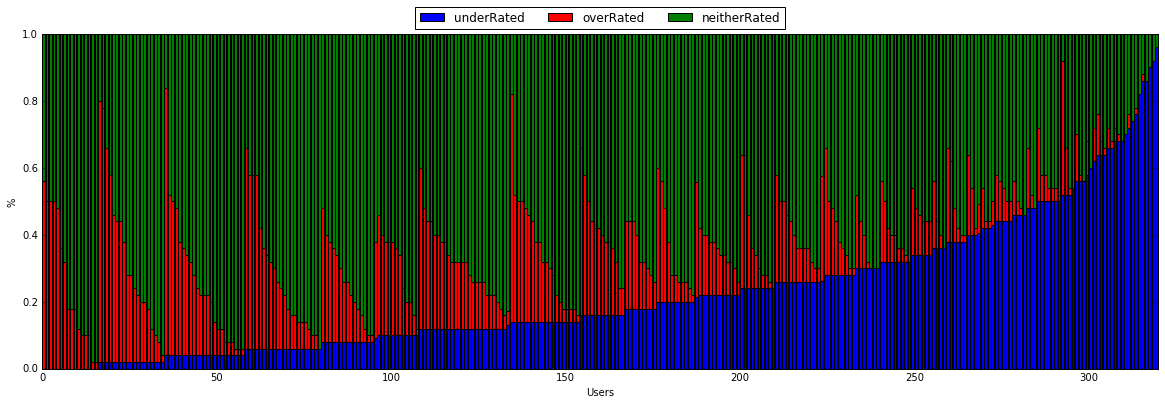

In [149]:
pcTuples.sort(key = lambda tup: tup[1])
pcTuples.sort(key = lambda tup: tup[2])
pcTuples.sort(key = lambda tup: tup[0])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
f = plt.figure(figsize = (20,6))
plt.bar(x, underRatedPcs, color = 'b', label='underRated')
plt.bar(x, overRatedPcs, color = 'r', bottom = underRatedPcs, label='overRated')
plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xlabel('Users')
plt.ylabel('%')

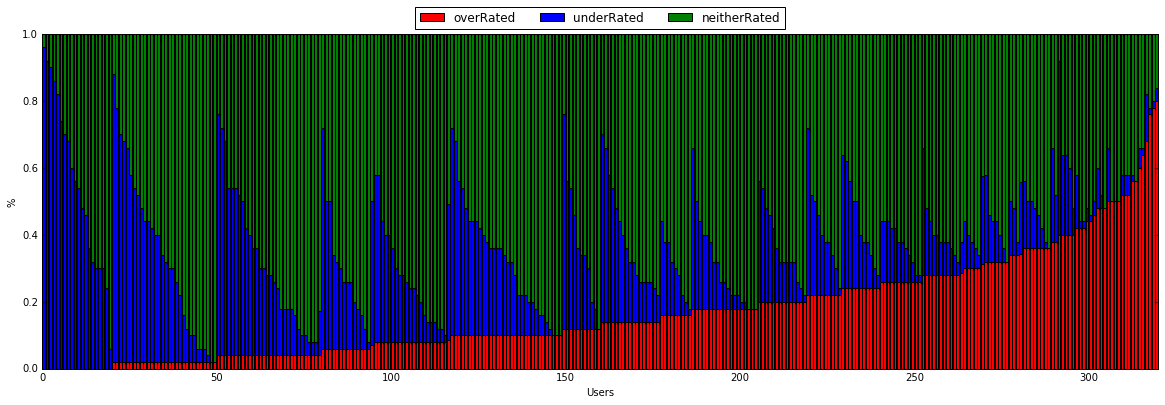

In [150]:
pcTuples.sort(key = lambda tup: tup[0])
pcTuples.sort(key = lambda tup: tup[2])
pcTuples.sort(key = lambda tup: tup[1])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
f = plt.figure(figsize = (20,6))
plt.bar(x, overRatedPcs, color = 'r', label='overRated')
plt.bar(x, underRatedPcs, color = 'b', bottom=overRatedPcs, label='underRated')
plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xlabel('Users')
plt.ylabel('%')

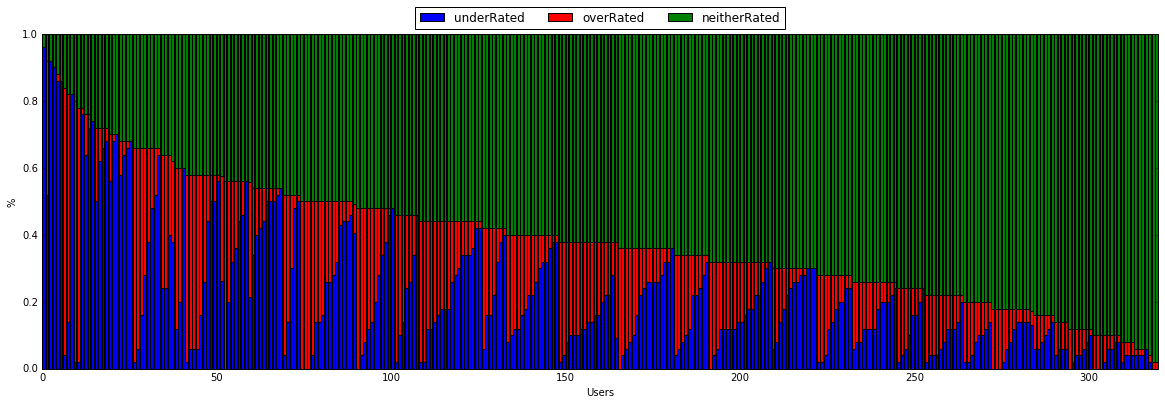

In [176]:
pcTuples.sort(key = lambda tup: tup[1])
pcTuples.sort(key = lambda tup: tup[0])
pcTuples.sort(key = lambda tup: tup[2])

nUsers = len(pcTuples)
x = range(nUsers)
underRatedPcs = []
overRatedPcs = []
neitherRatedPcs = []

for pcTuple in pcTuples:
    underRatedPcs.append(pcTuple[0])
    overRatedPcs.append(pcTuple[1])
    neitherRatedPcs.append(pcTuple[2])
f = plt.figure(figsize = (20,6))
plt.bar(x, underRatedPcs, color = 'b', label='underRated')
plt.bar(x, overRatedPcs, color = 'r', bottom = underRatedPcs, label='overRated')
plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
plt.axis("tight")
plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xlabel('Users')
plt.ylabel('%')

In [152]:
np.average(neitherRatedPcs), np.average(underRatedPcs), np.average(overRatedPcs)

(0.60976970609764192, 0.22023566541408551, 0.16999462848827257)

In [153]:
setsLabel = []
for user, setRatings in uSetRatings.iteritems():
    if len(setRatings) < 50:
        continue
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        setsLabel.append(setRatingType)

In [154]:
len(setsLabel)

16231

In [155]:
permSetsLabel = np.random.permutation(setsLabel)

In [91]:
float(len(permSetsLabel))/320

50.721875

In [173]:
def randLabels():
    permSetsLabel = np.random.permutation(setsLabel)
    uPermSetsPc = {}
    uPermPcTuples = []
    for u in range(320):
        start = u*50
        uSetsLabel = permSetsLabel[start:start+50]
        underCount = 0.0
        overCount = 0.0
        for label in uSetsLabel:
            if label == UNDER_RATED_SET:
                underCount += 1
            elif label == OVER_RATED_SET:
                overCount += 1
        neitherCount = 50.0 - (underCount + overCount)
        underPc   = underCount/50
        overPc    = overCount/50
        neitherPC = neitherCount/50
        uPermSetsPc[u] = [underPc, overPc, neitherPC]
        uPermPcTuples.append((underPc, overPc, neitherPC))
    uPermPcTuples.sort(key = lambda tup: tup[1])
    uPermPcTuples.sort(key = lambda tup: tup[0])
    uPermPcTuples.sort(key = lambda tup: tup[2])
    nUsers = len(uPermPcTuples)
    x = range(nUsers)
    underRatedPcs = []
    overRatedPcs = []
    neitherRatedPcs = []

    for pcTuple in uPermPcTuples:
        underRatedPcs.append(pcTuple[0])
        overRatedPcs.append(pcTuple[1])
        neitherRatedPcs.append(pcTuple[2])
    f = plt.figure(figsize = (20,6))
    #plt.bar(x, overRatedPcs, color = 'r', label='overRated')
    #plt.bar(x, underRatedPcs, color = 'b', bottom=overRatedPcs, label='underRated')
    plt.bar(x, underRatedPcs, color = 'b', label='underRated')
    plt.bar(x, overRatedPcs, color = 'r', bottom = underRatedPcs, label='overRated')
    plt.bar(x, neitherRatedPcs, color='g', bottom = [i+j  for i,j in zip(underRatedPcs, overRatedPcs)], label='neitherRated')
    plt.axis("tight")
    plt.legend(loc=9, bbox_to_anchor=(0.5, 1.1), ncol=3)
    plt.xlabel('Users')
    plt.ylabel('%')
    
    print np.average(underRatedPcs), np.average(overRatedPcs), np.average(neitherRatedPcs)
    return (underRatedPcs, overRatedPcs, neitherRatedPcs)

0.220625 0.1708125 0.6085625


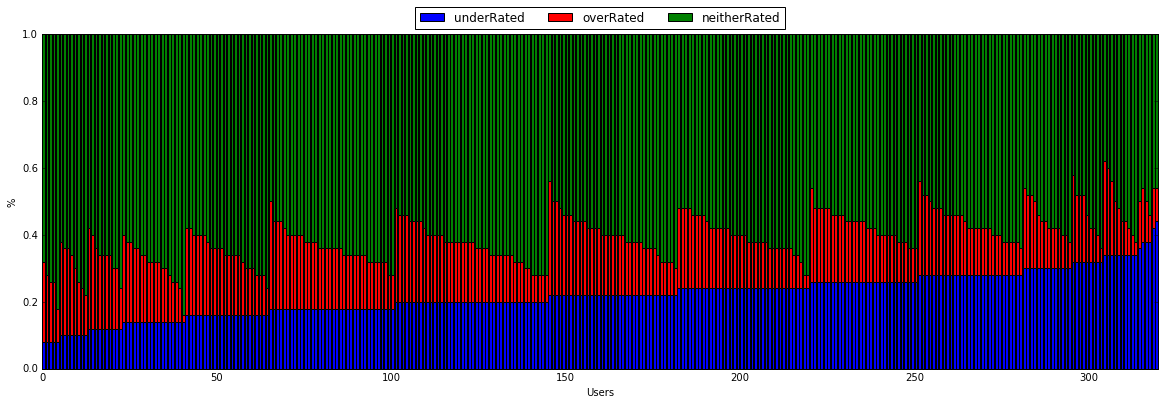

In [159]:
randLabels()

0.2206875 0.170625 0.6086875


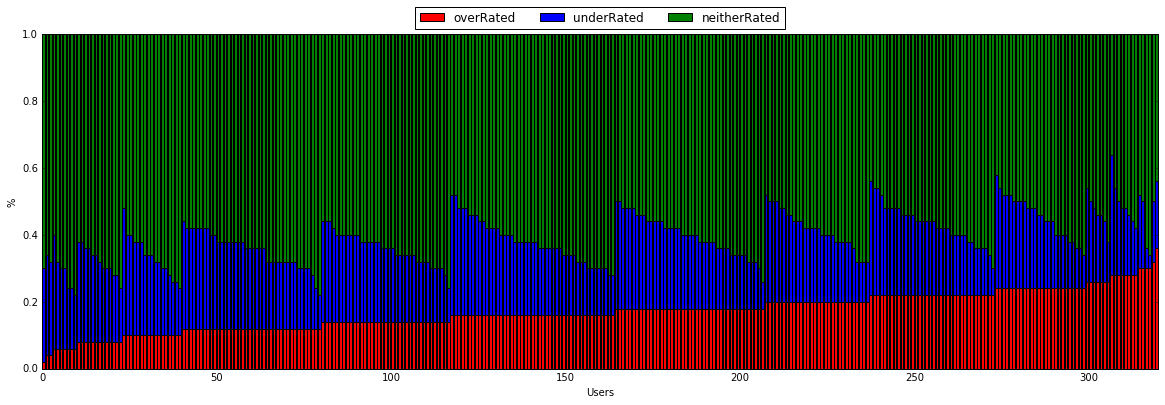

In [161]:
randLabels()

0.2200625 0.1705 0.6094375


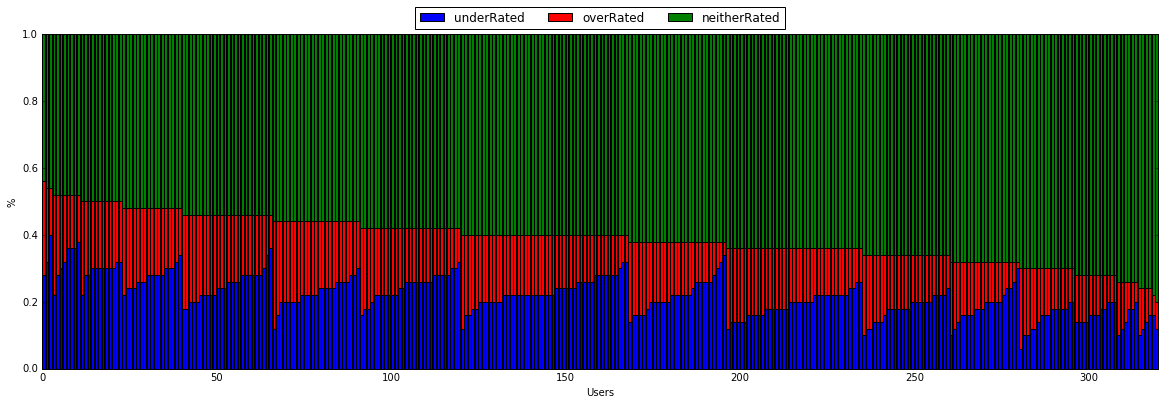

In [175]:
(randUnderRatedPcs, randOverRatedPcs, randNeitherRatedPcs) = randLabels()

In [187]:
print len(underRatedPcs), len(overRatedPcs)
diffRatedPcs = [ underRatedPcs[i] + neitherRatedPcs[i] for i in range(len(underRatedPcs))]
diffRandRatedPcs = [randUnderRatedPcs[i] + randNeitherRatedPcs[i] for i in range(len(randOverRatedPcs))]
print stats.ttest_ind(underRatedPcs, randUnderRatedPcs)
print stats.ttest_ind(overRatedPcs, randOverRatedPcs)
print stats.ttest_ind(neitherRatedPcs, randNeitherRatedPcs)
print stats.ttest_ind(diffRatedPcs, diffRandRatedPcs)

320 320
Ttest_indResult(statistic=0.015179086364678369, pvalue=0.98789405177093248)
Ttest_indResult(statistic=-0.056941637710800949, pvalue=0.95460951412952588)
Ttest_indResult(statistic=0.029842875289157789, pvalue=0.97620169715892402)
Ttest_indResult(statistic=0.056941637710804079, pvalue=0.95460951412952344)


In [164]:
itemRatingPair = {}
for user, setRatings in uSetRatings.iteritems():
    for setRating in setRatings:
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        for item in items:
            itemRating = uiRatings[user][item]
            if item not in itemRatingPair:
                itemRatingPair[item] = {}
            if itemRating not in itemRatingPair[item]:
                itemRatingPair[item][itemRating] = [0.0, 0.0, 0.0, 0.0] #[neitherCt, unCt, ovCt, total]
            itemRatingPair[item][itemRating][setRatingType] += 1
            itemRatingPair[item][itemRating][3] += 1
            
for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        itemRatingPair[item][rating][0] = itemRatingPair[item][rating][0]/itemRatingPair[item][rating][3]
        itemRatingPair[item][rating][1] = itemRatingPair[item][rating][1]/itemRatingPair[item][rating][3]
        itemRatingPair[item][rating][2] = itemRatingPair[item][rating][2]/itemRatingPair[item][rating][3]

neitherPc = []
overPc = []
underPc = []
for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        nSets = counts[3]
        if nSets >= 5:
            neitherPc.append(counts[NEITHER_RATED_SET])
            underPc.append(counts[UNDER_RATED_SET])
            overPc.append(counts[OVER_RATED_SET])
print 'avg neitherPc: ', np.average(neitherPc)
print 'avg underPc: ', np.average(underPc)
print 'avg overPc: ', np.average(overPc)

avg neitherPc:  0.604345726357
avg underPc:  0.222040770152
avg overPc:  0.173613503491


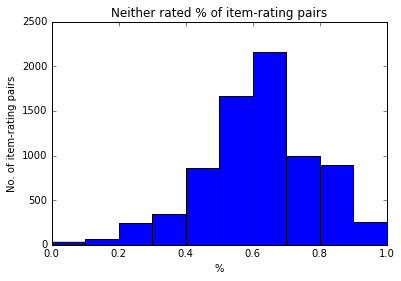

In [165]:
plt.hist(neitherPc)
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Neither rated % of item-rating pairs')

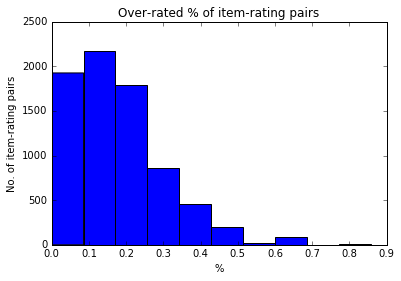

In [166]:
plt.hist(overPc);
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Over-rated % of item-rating pairs')

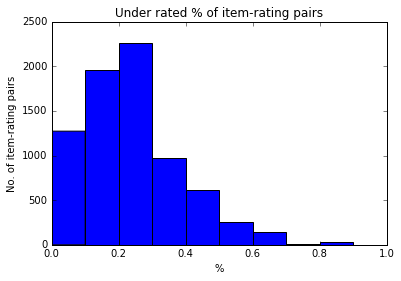

In [167]:
plt.hist(underPc);
plt.xlabel('%')
plt.ylabel('No. of item-rating pairs')
plt.title('Under rated % of item-rating pairs')

In [330]:
underSetCt = 0.0
loUnderCt = 0.0
hiUnderCt = 0.0

overSetCt = 0.0
loOverCt = 0.0
hiOverCt = 0.0

neitherSetCt = 0.0

for item, ratingNCount in itemRatingPair.iteritems():
    for rating, counts in ratingNCount.iteritems():
        nSets = counts[3]
        if nSets >= 5:
            if counts[UNDER_RATED_SET] > 0.22:
                underSetCt += 1
                if rating > 3:
                    hiUnderCt += 1
                else:
                    loUnderCt += 1
            if counts[OVER_RATED_SET] > 0.17:
                overSetCt += 1
                if rating > 3:
                    hiOverCt += 1
                else:
                    loOverCt += 1
                    
print "underRated itemRating pairs: ", underSetCt, "low rated: ", loUnderCt/underSetCt, 'high rated: ', hiUnderCt/underSetCt
print "overRated  itemRating pairs: ", overSetCt, "low rated: ", loOverCt/overSetCt, "high rated: ", hiOverCt/overSetCt

underRated itemRating pairs:  3322.0 low rated:  0.336243226972 high rated:  0.663756773028
overRated  itemRating pairs:  3417.0 low rated:  0.419959028387 high rated:  0.580040971613


In [182]:
stats.f_oneway(randOverRatedPcs, overRatedPcs)

F_onewayResult(statistic=0.0032423501050771342, pvalue=0.95460951412998996)

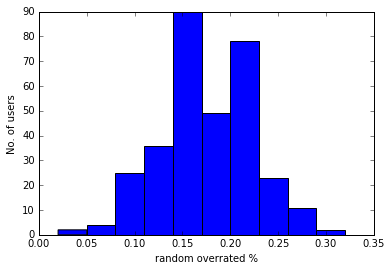

In [217]:
plt.hist(randOverRatedPcs)
plt.xlabel('random overrated %')
plt.ylabel('No. of users')

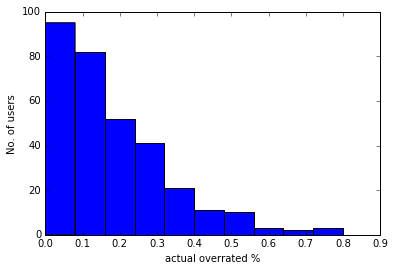

In [219]:
plt.hist(overRatedPcs)
plt.xlabel('actual overrated %')
plt.ylabel('No. of users')

In [191]:
np.average(overRatedPcs), np.average(randOverRatedPcs)

(0.16999462848827257, 0.17050000000000001)

In [223]:
np.std(overRatedPcs), np.std(randOverRatedPcs)
stats.ks_2samp(overRatedPcs, randOverRatedPcs)
stats.shapiro(randOverRatedPcs)
stats.mannwhitneyu(overRatedPcs, randOverRatedPcs)

MannwhitneyuResult(statistic=42435.5, pvalue=8.5974554544112169e-05)

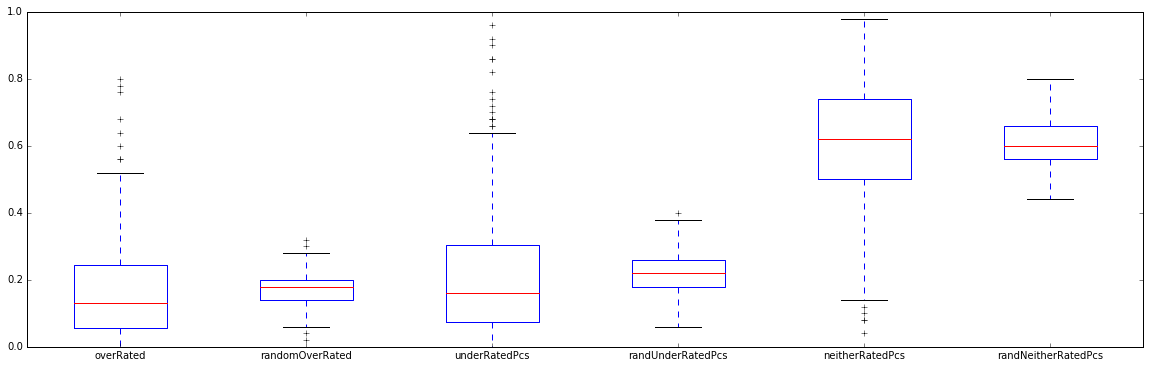

In [215]:
f = plt.figure(figsize=(20,6))
fig, ax = plt.subplots(1,1, figsize=(20,6))
ax.boxplot([overRatedPcs, randOverRatedPcs, underRatedPcs, randUnderRatedPcs, neitherRatedPcs, randNeitherRatedPcs])
ax.set_xticklabels(['overRated', 'randomOverRated', 'underRatedPcs', 'randUnderRatedPcs', 'neitherRatedPcs', 'randNeitherRatedPcs'])

In [274]:
def getOldestTstampSet(user, items):
    tstamps = []
    for item in items:
        tstamps.append(uiTstamp[user][item])
    tstamps.sort()
    return tstamps[0]

def getOldTstampSets(userSetRatings):
    oldTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldTstamps.append(getOldestTstampSet(user, items))
    return oldTstamps

def getOldTstampSetsDiff(userSetRatings):
    diffTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldestTstamp = getOldestTstampSet(user, items)
            latestTstamp = usersLatestTstamp[user]
            diffTstamps.append((latestTstamp  - oldestTstamp).total_seconds())
    return diffTstamps

def getOldTstampSetsLatestDiff(userSetRatings):
    diffTstamps = []
    for user, setRatings in userSetRatings.iteritems():
        for setRating in setRatings:
            items = setRating[0]
            oldestTstamp = getOldestTstampSet(user, items)
            latestTstamp = datetime.datetime.now()
            diffTstamps.append((latestTstamp  - oldestTstamp).total_seconds())
    return diffTstamps

def getUsersLatestTstamp():
    userLatestTstamp = {}
    for user, itemTstamp in uiTstamp.iteritems():
        uStamps = itemTstamp.values()
        uStamps.sort()
        userLatestTstamp[user] = uStamps[-1]
    return userLatestTstamp

In [276]:
uUnderRatedTstamps = getOldTstampSets(uUnderRatedSetRatings)
uOverRatedTstamps = getOldTstampSets(uOverRatedSetRatings)
uNeitherRatedTstamps = getOldTstampSets(uNeitherRatedSetRatings)

uUnderRatedTstampsDiff = getOldTstampSetsDiff(uUnderRatedSetRatings)
uOverRatedTstampsDiff = getOldTstampSetsDiff(uOverRatedSetRatings)
uNeitherRatedTstampsDiff = getOldTstampSetsDiff(uNeitherRatedSetRatings)

uUnderRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uUnderRatedSetRatings)
uOverRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uOverRatedSetRatings)
uNeitherRatedTstampsLatestDiff = getOldTstampSetsLatestDiff(uNeitherRatedSetRatings)

In [255]:
usersLatestTstamp = getUsersLatestTstamp()

In [265]:
uUnderRatedTstampsDiff[:3]

[9303541.0, 9312496.0, 9310307.0]

In [269]:
np.average(uUnderRatedTstampsDiff)/(3600*24), np.average(uOverRatedTstampsDiff)/(3600*24), np.average(uNeitherRatedTstampsDiff)/(3600*24)

(1734.2098617399263, 1361.1554936786044, 1369.616190470407)

In [270]:
stats.ttest_ind(uUnderRatedTstampsDiff, uOverRatedTstampsDiff)

Ttest_indResult(statistic=10.868173617063897, pvalue=2.2037049496178921e-27)

In [271]:
stats.ttest_ind(uOverRatedTstampsDiff, uNeitherRatedTstampsDiff)

Ttest_indResult(statistic=-0.30539158510113773, pvalue=0.76007070048876035)

In [273]:
stats.ttest_ind(uUnderRatedTstampsDiff, uNeitherRatedTstampsDiff)

Ttest_indResult(statistic=14.044730770507627, pvalue=1.2407885362481827e-44)

In [277]:
np.average(uUnderRatedTstampsLatestDiff)/(3600*24), np.average(uOverRatedTstampsLatestDiff)/(3600*24), np.average(uNeitherRatedTstampsLatestDiff)/(3600*24)

(1841.2685534553516, 1467.8213540153199, 1456.8060104256751)

In [279]:
print stats.ttest_ind(uUnderRatedTstampsLatestDiff, uOverRatedTstampsLatestDiff)
print stats.ttest_ind(uNeitherRatedTstampsLatestDiff, uOverRatedTstampsLatestDiff)
print stats.ttest_ind(uUnderRatedTstampsLatestDiff, uNeitherRatedTstampsLatestDiff)

Ttest_indResult(statistic=10.723759363233757, pvalue=1.0454089944224831e-26)
Ttest_indResult(statistic=-0.3944279295091444, pvalue=0.69326879303397637)
Ttest_indResult(statistic=14.653978147093945, pvalue=2.0453756568057031e-48)


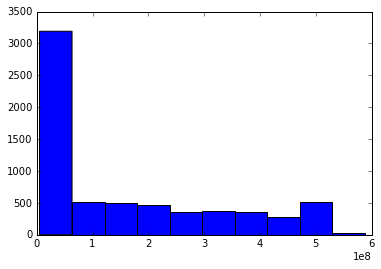

In [283]:
plt.hist(uUnderRatedTstampsLatestDiff);

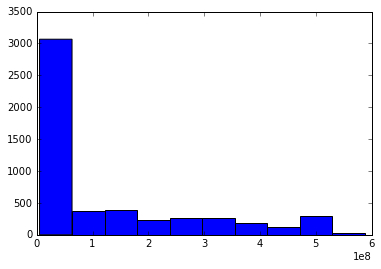

In [289]:
plt.hist(uOverRatedTstampsLatestDiff);

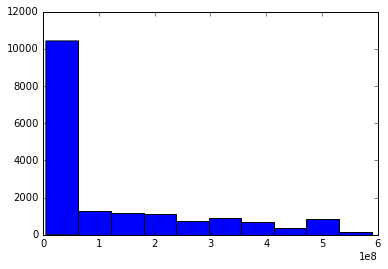

In [288]:
plt.hist(uNeitherRatedTstampsLatestDiff);

In [317]:
nSets = 0.0
nOldSets = 0.0
nOldUnderRatedSets = 0.0
nOldOverRatedSets = 0.0
nOldNeitherRatedSets = 0.0
uOldPcs = {}
for user, setRatings in uSetRatings.iteritems():
    uOldSets = 0.0
    uOldUnderRatedSets = 0.0
    uOldOverRatedSets = 0.0
    uOldNeitherRatedSets = 0.0
    for setRating in setRatings:
        nSets += 1
        items = setRating[0]
        rating = setRating[1]
        setRatingType = isSetUnderOverRat(user, items, rating)
        oldTstamp = getOldestTstampSet(user, items)
        tdiff = (usersLatestTstamp[user] - oldTstamp).total_seconds()
        diffDays = tdiff/(3600*24)
        if diffDays > 1500:
            #old movie in set
            nOldSets += 1
            uOldSets += 1
            if setRatingType == UNDER_RATED_SET:
                nOldUnderRatedSets += 1
                uOldUnderRatedSets += 1
            elif setRatingType == OVER_RATED_SET:
                nOldOverRatedSets += 1
                uOldOverRatedSets += 1
            else:
                nOldNeitherRatedSets += 1
                uOldNeitherRatedSets += 1
    if uOldSets > 0:
        uOldPcs[user] = [uOldUnderRatedSets/uOldSets, uOldOverRatedSets/uOldSets, uOldNeitherRatedSets/uOldSets, uOldSets]

In [295]:
#1370
print 'nOldSets: ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets:  10402.0
nOldUnderRatedSets:  0.269371274755
nOldOverRatedSets:  0.165160546049
nOldNeitherRatedSets:  0.565468179196


In [298]:
print 'nOldSets (1500days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (1500days and old):  9960.0
nOldUnderRatedSets:  0.273493975904
nOldOverRatedSets:  0.160040160643
nOldNeitherRatedSets:  0.566465863454


In [300]:
print 'nOldSets (2000 days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (2000 days and old):  8505.0
nOldUnderRatedSets:  0.279717813051
nOldOverRatedSets:  0.158612580835
nOldNeitherRatedSets:  0.561669606114


In [302]:
print 'nOldSets (3000 days and old): ', nOldSets
print 'nOldUnderRatedSets: ', nOldUnderRatedSets/nOldSets
print 'nOldOverRatedSets: ', nOldOverRatedSets/nOldSets
print 'nOldNeitherRatedSets: ', nOldNeitherRatedSets/nOldSets

nOldSets (3000 days and old):  5844.0
nOldUnderRatedSets:  0.274640657084
nOldOverRatedSets:  0.170431211499
nOldNeitherRatedSets:  0.554928131417


In [318]:
len(uOldPcs)

247

In [319]:
uOldPcsUn = [tup[0] for tup in uOldPcs.values()]
uOldPcsOv = [tup[1] for tup in uOldPcs.values()]
uOldPcsNe = [tup[2] for tup in uOldPcs.values()]

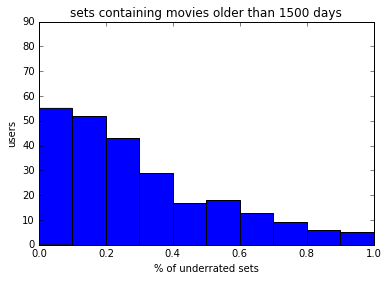

In [327]:
f = plt.figure()
ax = f.add_subplot(1, 1, 1)
ax.hist(uOldPcsUn)
ax.set_ylim(0,90)
ax.set_xlabel('% of underrated sets')
ax.set_ylabel('users')
ax.set_title('sets containing movies older than 1500 days')

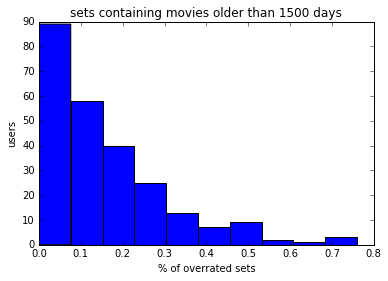

In [328]:
plt.hist(uOldPcsOv);
plt.xlabel('% of overrated sets')
plt.ylabel('users')
plt.title('sets containing movies older than 1500 days')

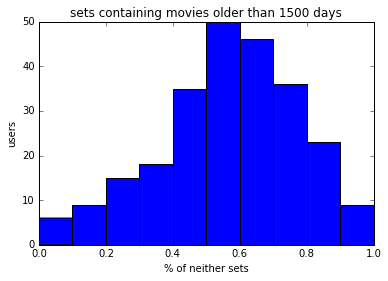

In [329]:
plt.hist(uOldPcsNe);
plt.xlabel('% of neither sets')
plt.ylabel('users')
plt.title('sets containing movies older than 1500 days')